# 2D Elastic Wave PINN Forward Problem Validation

## 概要

本ノートブックは、Phase 2（pinn-2d-fdtd-integration）で実装された2D弾性波PINNコンポーネントを用いて、順問題の完全なワークフローを実証します。

### 目的

- FDTDデータを用いた2D PINN訓練の実行
- 訓練中の損失項（L_data, L_pde, L_bc）モニタリング
- R²スコアによる定量評価
- 2D波動場の空間分布可視化
- 誤差分布の空間解析

### 前提条件

- Phase 2実装（pinn-2d-fdtd-integration）が完了していること
- `PINN_data/`に.npzファイル（最低2ファイル）が配置されていること
- GPU環境（CUDA 12.4対応）推奨

### 実行環境

- Python 3.11+
- PyTorch 2.4.0 with CUDA 12.4
- DeepXDE 1.15.0

## Step 0: セットアップとインポート

Phase 2実装のServiceクラスをimportし、再現性を確保するためにrandom seedを設定します。

In [2]:
# Standard library imports
import sys
from pathlib import Path
import time

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# PINN module imports (Phase 2 implementation)
from pinn.data.fdtd_loader import FDTDDataLoaderService
from pinn.data.dimensionless_scaler import CharacteristicScales, DimensionlessScalerService
from pinn.models.pinn_model_builder_2d import PINNModelBuilder2DService
from pinn.models.pde_definition_2d import PDEDefinition2DService
from pinn.training.train_2d import TrainingPipelineService
from pinn.training.callbacks import LossLoggingCallback, R2ValidationCallback, DivergenceDetectionCallback
from pinn.validation.r2_score import R2ScoreCalculator
from pinn.validation.plot_generator import PlotGeneratorService
from pinn.utils.seed_manager import SeedManager

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

# Set random seed for reproducibility (Requirement 7.4)
SEED = 42
SeedManager.set_seed(SEED)
print(f"Random seed set to: {SEED}")

# Check GPU availability (Requirement 2.9)
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: GPU not available, training will be slow on CPU")

Random seed set to: 42

PyTorch version: 2.4.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060


## Step 1: FDTDデータの読み込みと無次元化

このステップでは、`PINN_data/`ディレクトリからFDTDシミュレーションデータを読み込み、無次元化を適用します。

### タスク2.1: データファイル読み込み
- FDTDデータファイルの検索と読み込み
- データディレクトリの存在確認（Requirement 1.7）
- データセットサイズの表示（Requirement 1.2）

### タスク2.2: 無次元化と変数範囲表示
- 特性スケールの計算（Requirement 1.3）
- 無次元化後の変数範囲表示（Requirement 1.4）

### タスク2.3: Train/Val分割
- 訓練データとバリデーションデータの分割（Requirement 1.5）

In [3]:
# Task 2.1: FDTD data file loading (Requirements 1.1, 1.2, 1.7)
# Data directory
data_dir = Path.cwd().parent / "PINN_data"

# Check if data directory exists (Requirement 1.7)
if not data_dir.exists():
    raise FileNotFoundError(
        f"Data directory not found: {data_dir}\n"
        "Please create PINN_data/ in project root and place FDTD .npz files there.\n"
        "Expected naming: p{pitch_um}_d{depth_um}.npz (e.g., p1250_d100.npz)"
    )

# Load FDTD data files (Requirement 1.1)
npz_files = sorted(data_dir.glob("p*_d*.npz"))
if len(npz_files) < 2:
    raise ValueError(
        f"Insufficient data files: {len(npz_files)} found, need at least 2.\nPlease add FDTD .npz files to {data_dir}"
    )

print(f"Found {len(npz_files)} FDTD data files:")
for f in npz_files:
    print(f"  - {f.name}")

# Create FDTD data loader (Phase 2 Service)
loader = FDTDDataLoaderService(data_dir=data_dir)

# Load elastic constants (for dimensionless scaling)
elastic_lambda = 51.2e9  # Pa (Aluminum 6061-T6)
elastic_mu = 26.1e9  # Pa
density = 2700.0  # kg/m³

# Load first file to estimate displacement scale
sample_data = loader.load_file(npz_files[0])
U_ref = np.std(np.concatenate([sample_data.Ux, sample_data.Uy]))

print(f"\nEstimated U_ref: {U_ref:.2e} m")

# Task 2.2: Create characteristic scales (Requirement 1.3)
scales = CharacteristicScales.from_physics(
    domain_length=0.04,  # 40mm
    elastic_lambda=elastic_lambda,
    elastic_mu=elastic_mu,
    density=density,
    displacement_amplitude=U_ref,
)

# Create scaler
scaler = DimensionlessScalerService(scales)

print(f"\nCharacteristic scales:")
print(f"  L_ref = {scales.L_ref:.4f} m")
print(f"  T_ref = {scales.T_ref:.2e} s")
print(f"  U_ref = {scales.U_ref:.2e} m")
print(f"  σ_ref = {scales.sigma_ref:.2e} Pa")
print(f"  c_l   = {scales.velocity_ref:.0f} m/s")

# Load and normalize data (Requirement 1.2)
start_time = time.time()
dataset = loader.load_multiple_files(npz_files, apply_dimensionless=True, scaler=scaler)
load_time = time.time() - start_time

print(f"\n✓ Loaded {len(dataset.x)} samples from {len(npz_files)} file(s) in {load_time:.2f}s")

# Task 2.2: Display dimensionless variable ranges (Requirement 1.4)
print(f"\nData ranges (dimensionless):")
print(f"  x̃:  [{np.min(dataset.x):.3f}, {np.max(dataset.x):.3f}]")
print(f"  ỹ:  [{np.min(dataset.y):.3f}, {np.max(dataset.y):.3f}]")
print(f"  t̃:  [{np.min(dataset.t):.3f}, {np.max(dataset.t):.3f}]")
print(f"  T̃1: [{np.min(dataset.T1):.3f}, {np.max(dataset.T1):.3f}]")
print(f"  T̃3: [{np.min(dataset.T3):.3f}, {np.max(dataset.T3):.3f}]")
print(f"  Ũx: [{np.min(dataset.Ux):.3f}, {np.max(dataset.Ux):.3f}]")
print(f"  Ũy: [{np.min(dataset.Uy):.3f}, {np.max(dataset.Uy):.3f}]")

# Task 2.3: Train/val split (Requirement 1.5)
train_data, val_data = loader.train_val_split(dataset, train_ratio=0.8, seed=SEED)
print(f"\nTrain samples: {len(train_data.x)}")
print(f"Val samples: {len(val_data.x)}")

Found 12 FDTD data files:
  - p1250_d100.npz
  - p1250_d200.npz
  - p1250_d300.npz
  - p1500_d100.npz
  - p1500_d200.npz
  - p1500_d300.npz
  - p1750_d100.npz
  - p1750_d200.npz
  - p1750_d300.npz
  - p2000_d100.npz
  - p2000_d200.npz
  - p2000_d300.npz

Estimated U_ref: 1.12e-09 m

Characteristic scales:
  L_ref = 0.0400 m
  T_ref = 6.46e-06 s
  U_ref = 1.12e-09 m
  σ_ref = 1.03e+11 Pa
  c_l   = 6188 m/s

✓ Loaded 960000 samples from 12 file(s) in 0.10s

Data ranges (dimensionless):
  x̃:  [0.000, 0.500]
  ỹ:  [0.000, 1.000]
  t̃:  [0.542, 1.545]
  T̃1: [-0.000, 0.000]
  T̃3: [-0.000, 0.000]
  Ũx: [-33.733, 37.007]
  Ũy: [-14.271, 20.390]

Train samples: 768000
Val samples: 192000


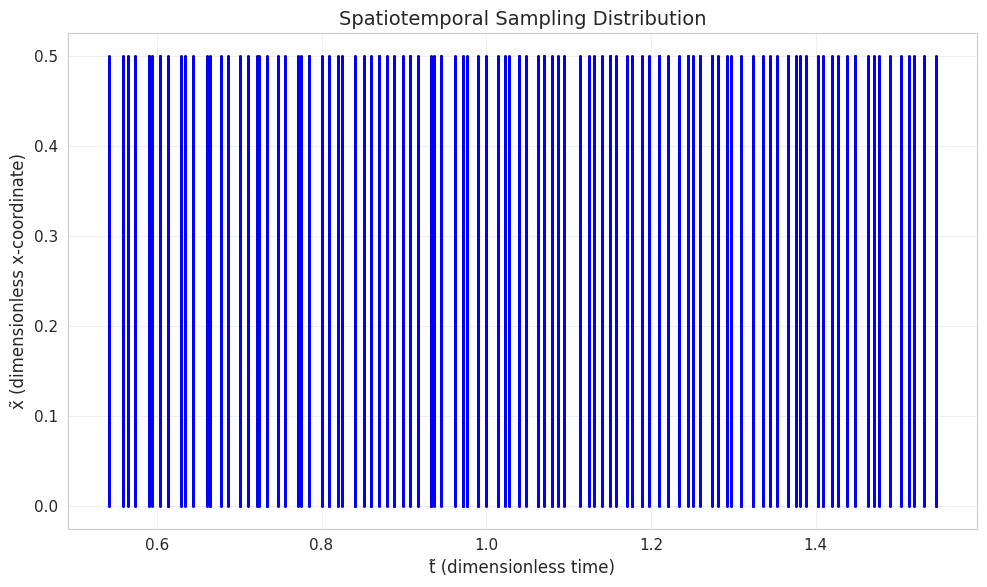


✓ Data preparation complete (Tasks 2.1, 2.2, 2.3)


In [4]:
# Task 2.3: Visualize spatiotemporal distribution (Requirement 1.6)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(dataset.t, dataset.x, s=0.5, alpha=0.3, c="blue")
ax.set_xlabel("t̃ (dimensionless time)", fontsize=12)
ax.set_ylabel("x̃ (dimensionless x-coordinate)", fontsize=12)
ax.set_title("Spatiotemporal Sampling Distribution", fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Data preparation complete (Tasks 2.1, 2.2, 2.3)")

## Step 2: 2D PINNモデルの構築

このステップでは、Phase 2のPINNModelBuilder2DServiceを使用して2D PINNモデルを構築します。

### タスク3.1: 設定パラメータ定義とモデル構築
- 設定パラメータの定義（Requirement 2.1）
- 5D入力、4D出力のPINNモデル構築（Requirement 2.2）
- PDEDefinition2DServiceのPDE関数適用（Requirement 2.3）
- API整合性確保（Requirement 8.3）

**推奨実行時間**: 約10-30秒（モデル構築のみ、訓練は次ステップ）

In [5]:
# Task 3.1: Configuration parameters definition (Requirement 2.1)
# Define PINN configuration parameters using Python dictionary format

config = {
    "network": {
        # 5D input: (x̃, ỹ, t̃, pitch_norm, depth_norm) (Requirement 2.2)
        # 4D output: (T̃1, T̃3, Ũx, Ũy)
        "layer_sizes": [5, 64, 64, 64, 4],
        "activation": "tanh",  # tanh activation for smooth approximation
    },
    "training": {
        "epochs": 5000,  # Minimum 1000, recommended 5000 (Requirement 2.4)
        "learning_rate": 0.001,  # Initial learning rate
        "loss_weights": {
            "data": 1.0,  # Weight for data fitting loss (L_data)
            "pde": 1.0,  # Weight for PDE residual loss (L_pde)
            "bc": 0.0,  # Weight for boundary condition loss (L_bc)
        },
    },
}

print("Configuration parameters:")
print(f"  Network architecture: {config['network']['layer_sizes']}")
print(f"  Input dimension: {config['network']['layer_sizes'][0]} (x̃, ỹ, t̃, pitch_norm, depth_norm)")
print(f"  Output dimension: {config['network']['layer_sizes'][-1]} (T̃1, T̃3, Ũx, Ũy)")
print(f"  Hidden layers: {config['network']['layer_sizes'][1:-1]}")
print(f"  Activation: {config['network']['activation']}")
print(f"  Epochs: {config['training']['epochs']}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(
    f"  Loss weights: L_data={config['training']['loss_weights']['data']}, L_pde={config['training']['loss_weights']['pde']}, L_bc={config['training']['loss_weights']['bc']}"
)

# Verify layer dimensions (Requirement 2.2)
assert config["network"]["layer_sizes"][0] == 5, "Input dimension must be 5"
assert config["network"]["layer_sizes"][-1] == 4, "Output dimension must be 4"
print("\n✓ Configuration validated")

# Task 3.1: Model construction (Requirements 2.2, 8.3)
print("\nConstructing PINN model...")

# Create model builder service (Phase 2 implementation)
builder = PINNModelBuilder2DService()

# Create PDE definition service for physics constraints (Requirement 2.3)
pde_service = PDEDefinition2DService(elastic_lambda=elastic_lambda, elastic_mu=elastic_mu, density=density, scales=scales)

# Build 2D PINN model with 5D input, 4D output
# This creates a DeepXDE model with the specified architecture
model = builder.build_model(config)

print("✓ PINN model constructed successfully")
print(f"  Model type: {type(model)}")

# Get PDE function for physics constraints (Requirement 2.3)
pde_function = pde_service.create_pde_function()

print("✓ PDE function created for physics constraints")
print(f"  PDE type: Dimensionless 2D elastic wave equation")

# Verify model construction
assert model is not None, "Model construction failed"
print("\n✓ Model construction complete (Task 3.1)")

Configuration parameters:
  Network architecture: [5, 64, 64, 64, 4]
  Input dimension: 5 (x̃, ỹ, t̃, pitch_norm, depth_norm)
  Output dimension: 4 (T̃1, T̃3, Ũx, Ũy)
  Hidden layers: [64, 64, 64]
  Activation: tanh
  Epochs: 5000
  Learning rate: 0.001
  Loss weights: L_data=1.0, L_pde=1.0, L_bc=0.0

✓ Configuration validated

Constructing PINN model...


TypeError: PDEDefinition2DService() takes no arguments

## Step 3: 訓練実行と損失監視

このステップでは、TrainingPipelineServiceを使用してPINN訓練を実行し、損失項をリアルタイムで監視します。

### タスク4.1: 訓練実行と損失ロギング
- LossLoggingCallback、R2ValidationCallback、DivergenceDetectionCallbackの設定
- TrainingPipelineServiceによる訓練実行（Requirements 2.4, 2.5）
- 訓練時間の記録（GPU使用時）（Requirement 2.9）
- 個別損失項（L_data, L_pde, L_bc）とtotal lossの表示（Requirement 2.6）

### タスク4.2: 訓練履歴プロットとNaN検出
- PlotGeneratorServiceによる訓練履歴の4系列プロット（Requirement 2.7）
- DivergenceDetectionCallbackによるNaN loss検出（Requirement 2.8）
- 訓練収束性の視覚的確認

**推奨実行時間**: GPU: 約10-15分（5000 epochs）、CPU: 約60-90分

In [ ]:
# Task 4.1: Training execution and loss logging (Requirements 2.4, 2.5, 2.6, 2.9)

# Prepare validation data for R2ValidationCallback
# Validation input: (N_val, 5) [x, y, t, pitch_norm, depth_norm]
val_x = np.column_stack([val_data.x, val_data.y, val_data.t, val_data.pitch_norm, val_data.depth_norm])

# Validation output: (N_val, 4) [T1, T3, Ux, Uy]
val_y = np.column_stack([val_data.T1, val_data.T3, val_data.Ux, val_data.Uy])

print(f"Validation data prepared:")
print(f"  val_x shape: {val_x.shape}")
print(f"  val_y shape: {val_y.shape}")

# Create output directory for training artifacts
output_dir = Path.cwd().parent / "experiments" / "forward_validation"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\nOutput directory: {output_dir}")

# Configure callbacks (Requirement 2.5, 2.8)
callbacks = [
    LossLoggingCallback(log_interval=100),  # Log every 100 epochs (Requirement 2.6)
    R2ValidationCallback(
        val_x=val_x,
        val_y=val_y,
        r2_threshold=0.9,
        log_interval=1000,  # Compute R² every 1000 epochs
    ),
    DivergenceDetectionCallback(
        output_dir=output_dir,
        nan_threshold=1e10,  # Halt if loss exceeds threshold (Requirement 2.8)
    ),
]

print("\n✓ Callbacks configured:")
print("  - LossLoggingCallback (log_interval=100)")
print("  - R2ValidationCallback (r2_threshold=0.9, log_interval=1000)")
print("  - DivergenceDetectionCallback (nan_threshold=1e10)")

# Create training pipeline service
training_pipeline = TrainingPipelineService()

# Record training start time (Requirement 2.9)
print(f"\nStarting training with {config['training']['epochs']} epochs...")
print(f"GPU available: {torch.cuda.is_available()}")
training_start_time = time.time()

# Execute training (Requirement 2.4)
trained_model, history = training_pipeline.train(model=model, config=config, output_dir=output_dir, callbacks=callbacks)

# Record training end time (Requirement 2.9)
training_end_time = time.time()
training_duration = training_end_time - training_start_time

print(f"\n{'=' * 60}")
print(f"Training Complete")
print(f"{'=' * 60}")
print(f"Training time: {training_duration:.2f} seconds ({training_duration / 60:.2f} minutes)")
print(f"Epochs completed: {config['training']['epochs']}")
print(f"Final losses:")
if history:
    if "L_data" in history and len(history["L_data"]) > 0:
        print(f"  L_data: {history['L_data'][-1]:.6e}")
    if "L_pde" in history and len(history["L_pde"]) > 0:
        print(f"  L_pde: {history['L_pde'][-1]:.6e}")
    if "L_bc" in history and len(history["L_bc"]) > 0:
        print(f"  L_bc: {history['L_bc'][-1]:.6e}")
    if "total_loss" in history and len(history["total_loss"]) > 0:
        print(f"  Total: {history['total_loss'][-1]:.6e}")

print("\n✓ Training execution complete (Task 4.1)")

In [ ]:
# Task 4.2: Training history plot and convergence check (Requirement 2.7)

# Create plot generator service
plot_generator = PlotGeneratorService()

# Plot training curves with 4 series: L_data, L_pde, L_bc, Total loss (Requirement 2.7)
print("Generating training history plot...")

fig, ax = plot_generator.plot_training_curves(
    history=history,
    save_path=output_dir / "training_history.png",
    log_scale=False,  # Linear scale for better visual interpretation
)

plt.tight_layout()
plt.show()

print(f"✓ Training history plot saved to: {output_dir / 'training_history.png'}")

# Visual convergence check (Requirement 2.7)
print("\nTraining convergence analysis:")
if history and "total_loss" in history and len(history["total_loss"]) > 100:
    initial_loss = history["total_loss"][0]
    final_loss = history["total_loss"][-1]
    loss_reduction = (initial_loss - final_loss) / initial_loss * 100

    print(f"  Initial total loss: {initial_loss:.6e}")
    print(f"  Final total loss: {final_loss:.6e}")
    print(f"  Loss reduction: {loss_reduction:.2f}%")

    if loss_reduction > 50:
        print("  ✓ Good convergence: Loss reduced by >50%")
    elif loss_reduction > 20:
        print("  ⚠ Moderate convergence: Loss reduced by >20% but <50%")
        print("    Recommendation: Consider increasing epochs or adjusting learning rate")
    else:
        print("  ✗ Poor convergence: Loss reduced by <20%")
        print("    Recommendation: Check loss weights, learning rate, or network architecture")
else:
    print("  Warning: Insufficient training history for convergence analysis")

# Check if DivergenceDetectionCallback detected any issues (Requirement 2.8)
divergence_diagnostic_path = output_dir / "divergence_diagnostic.json"
if divergence_diagnostic_path.exists():
    print("\n⚠ WARNING: NaN loss detected during training!")
    print(f"  Diagnostic file: {divergence_diagnostic_path}")
    print("  Recommendations:")
    print("    - Reduce learning rate (try 0.0001 instead of 0.001)")
    print("    - Adjust loss weights (try w_pde=0.1 if PDE loss dominates)")
    print("    - Check input data normalization")
else:
    print("\n✓ No NaN loss detected - training was stable")

print("\n✓ Training history visualization complete (Task 4.2)")

## Step 4: R²スコア評価

このステップでは、訓練済みモデルでバリデーションデータ予測を実行し、R²スコアで定量評価します。

### タスク5.1: R²スコア計算と表形式表示
- バリデーションデータでPINN予測実行（Requirement 3.1）
- R2ScoreCalculatorで各出力場のR²計算（Requirement 3.2）
- pandas DataFrameで表形式表示（Requirement 3.3）

### タスク5.2: R²スコアbar chart可視化と解釈
- matplotlib bar chartでR²可視化（Requirement 3.4）
- 各フィールドの予測精度解釈コメント（Requirement 3.5）
- R² < 0.9のフィールドに改善策提案（Requirement 3.6）

**推奨実行時間**: 約1-2分（予測とR²計算）

In [ ]:
# Task 5.1: R² score calculation and table display (Requirements 3.1, 3.2, 3.3)

print("=" * 60)
print("Step 4: R² Score Evaluation")
print("=" * 60)

# Execute PINN prediction on validation data (Requirement 3.1)
print("\nExecuting PINN prediction on validation data...")
prediction_start_time = time.time()

y_pred_array = trained_model.predict(val_x)

prediction_end_time = time.time()
prediction_duration = prediction_end_time - prediction_start_time

print(f"✓ Prediction complete in {prediction_duration:.2f} seconds")
print(f"  Prediction shape: {y_pred_array.shape}")
print(f"  Expected shape: {val_y.shape}")

# Verify prediction shape matches ground truth
assert y_pred_array.shape == val_y.shape, f"Shape mismatch: {y_pred_array.shape} vs {val_y.shape}"

# Convert array format to dict format for R2ScoreCalculator (Requirement 3.2)
# Ground truth: val_y is (N_val, 4) [T1, T3, Ux, Uy]
y_true_dict = {"T1": val_y[:, 0], "T3": val_y[:, 1], "Ux": val_y[:, 2], "Uy": val_y[:, 3]}

# Predictions: y_pred_array is (N_val, 4)
y_pred_dict = {"T1": y_pred_array[:, 0], "T3": y_pred_array[:, 1], "Ux": y_pred_array[:, 2], "Uy": y_pred_array[:, 3]}

print("\n✓ Data converted to dict format for R² calculation")
print(f"  Fields: {list(y_true_dict.keys())}")

# Calculate R² scores for each output field (Requirement 3.2)
print("\nCalculating R² scores for each output field...")

calculator = R2ScoreCalculator()
r2_scores = calculator.compute_r2_multi_output(y_true_dict, y_pred_dict)

print("✓ R² scores calculated successfully")

# Display R² scores as pandas DataFrame (Requirement 3.3)
print("\n" + "-" * 60)
print("R² Score Summary (Table Format)")
print("-" * 60)

df_r2 = pd.DataFrame([r2_scores]).T
df_r2.columns = ["R² Score"]
df_r2.index.name = "Output Field"

print(df_r2.to_string())
print("-" * 60)

# Display individual R² values with details
print("\nDetailed R² Scores:")
for field, r2 in r2_scores.items():
    print(f"  {field}: R² = {r2:.6f}")

print("\n✓ R² score calculation and table display complete (Task 5.1)")

In [ ]:
# Task 5.2: R² score bar chart visualization and interpretation (Requirements 3.4, 3.5, 3.6)

# Generate bar chart for R² scores (Requirement 3.4)
print("\nGenerating R² score bar chart...")

fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart
fields = list(r2_scores.keys())
scores = list(r2_scores.values())
colors = ["#2ecc71" if r2 >= 0.9 else "#e74c3c" if r2 < 0.8 else "#f39c12" for r2 in scores]

bars = ax.bar(fields, scores, color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)

# Add reference line at R² = 0.9 (target threshold)
ax.axhline(y=0.9, color="red", linestyle="--", linewidth=2, label="Target Threshold (0.9)", alpha=0.7)

# Customize chart
ax.set_ylabel("R² Score", fontsize=14, fontweight="bold")
ax.set_xlabel("Output Field", fontsize=14, fontweight="bold")
ax.set_title("R² Score Validation: PINN vs FDTD Ground Truth", fontsize=16, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis="y")
ax.legend(fontsize=12)

# Add value labels on top of bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.02,
        f"{score:.4f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig(output_dir / "r2_scores_bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Bar chart saved to: {output_dir / 'r2_scores_bar_chart.png'}")

# Generate interpretation comments for each field (Requirement 3.5)
print("\n" + "=" * 60)
print("R² Score Interpretation")
print("=" * 60)

for field, r2 in r2_scores.items():
    # Classify prediction quality
    if r2 >= 0.95:
        quality = "高精度 (Excellent)"
        icon = "✓✓"
    elif r2 >= 0.9:
        quality = "良好 (Good)"
        icon = "✓"
    elif r2 >= 0.8:
        quality = "要改善 (Needs Improvement)"
        icon = "⚠"
    else:
        quality = "改善必須 (Poor - Action Required)"
        icon = "✗"

    print(f"{icon} {field}: R²={r2:.4f} ({quality})")

print("=" * 60)

# Provide improvement suggestions for fields with R² < 0.9 (Requirement 3.6)
fields_needing_improvement = {field: r2 for field, r2 in r2_scores.items() if r2 < 0.9}

if fields_needing_improvement:
    print("\n⚠ WARNING: Some fields have R² < 0.9 (below target threshold)")
    print("\n以下のフィールドは改善が推奨されます:")
    for field, r2 in fields_needing_improvement.items():
        deficit = 0.9 - r2
        print(f"  - {field}: R²={r2:.4f} (目標まで {deficit:.4f} 不足)")

    print("\n推奨される改善策:")
    print("  1. Loss weightの調整:")
    print("     - data loss weightを増加（現在1.0 → 2.0-5.0へ）")
    print("     - 特に低R²フィールドに対応する出力のweightを調整")
    print("  2. Epochs数の増加:")
    print(f"     - 現在{config['training']['epochs']} epochs → 10000 epochsへ増加")
    print("     - 損失履歴プロットで収束を確認")
    print("  3. Networkの拡大:")
    print(f"     - Hidden layer sizeを増加（現在{config['network']['layer_sizes'][1]} → 128または256へ）")
    print(f"     - Hidden layersを追加（現在{len(config['network']['layer_sizes']) - 2}層 → 4-5層へ）")
    print("  4. Learning rateの調整:")
    print(f"     - 学習率を下げる（現在{config['training']['learning_rate']} → 0.0005または0.0001へ）")
    print("  5. Collocation pointsの増加:")
    print("     - より多くの訓練データを使用（現在のtrain/val比率を調整）")
else:
    print("\n✓ 優秀な結果: 全フィールドがR² ≥ 0.9を達成しました！")
    print("  PINN予測はFDTD ground truthと高精度で一致しています。")

# Summary statistics
print("\n" + "-" * 60)
print("R² Score Statistics")
print("-" * 60)
mean_r2 = np.mean(list(r2_scores.values()))
min_r2 = np.min(list(r2_scores.values()))
max_r2 = np.max(list(r2_scores.values()))
min_field = min(r2_scores, key=r2_scores.get)
max_field = max(r2_scores, key=r2_scores.get)

print(f"  Mean R²: {mean_r2:.4f}")
print(f"  Min R²:  {min_r2:.4f} ({min_field})")
print(f"  Max R²:  {max_r2:.4f} ({max_field})")
print(f"  Range:   {max_r2 - min_r2:.4f}")
print("-" * 60)

print("\n✓ R² score visualization and interpretation complete (Task 5.2)")

## Step 5: 2D波動場の時刻スナップショット可視化

このステップでは、PlotGeneratorServiceを使用して2D波動場の時刻スナップショットを可視化し、FDTD ground truthとPINN予測を視覚的に比較します。

### タスク6.1: 時刻スナップショット可視化セル実装
- 時系列から3-5時刻を選択（Requirement 4.1）
- PlotGeneratorService.plot_time_snapshots()でFDTD vs PINN比較プロット（Requirements 4.2, 4.3, 4.4）
- Ux変位場の空間分布（x-y平面heatmap）を表示
- FDTDとPINNのheatmapを並列配置（side-by-side）
- 波動伝播パターン（波面位置、振幅分布）の解説（Requirement 4.5）

**推奨実行時間**: 約30秒-1分（データ準備と可視化生成）

In [ ]:
# Task 6.1: Time snapshot visualization (Requirements 4.1, 4.2, 4.3, 4.4, 4.5, 4.6)

print("=" * 60)
print("Step 5: 2D Wave Field Time Snapshot Visualization")
print("=" * 60)

# Step 1: Prepare data for 2D spatial visualization
# We need to restructure validation data into 2D grids for each time snapshot

# Extract unique spatial and temporal coordinates
x_unique = np.unique(val_data.x)
y_unique = np.unique(val_data.y)
t_unique = np.unique(val_data.t)

print(f"\nData dimensions:")
print(f"  Unique x coordinates: {len(x_unique)}")
print(f"  Unique y coordinates: {len(y_unique)}")
print(f"  Unique time points: {len(t_unique)}")
print(f"  Total validation samples: {len(val_data.x)}")

# Select 3-5 time snapshots (Requirement 4.1)
# Choose evenly spaced snapshots: early, mid-early, middle, mid-late, late
n_snapshots = min(5, len(t_unique))
if n_snapshots >= 5:
    snapshot_indices = [
        len(t_unique) // 5,  # 20% through
        2 * len(t_unique) // 5,  # 40% through
        len(t_unique) // 2,  # 50% through (middle)
        3 * len(t_unique) // 5,  # 60% through
        4 * len(t_unique) // 5,  # 80% through
    ]
elif n_snapshots >= 3:
    snapshot_indices = [
        len(t_unique) // 4,  # 25% through
        len(t_unique) // 2,  # 50% through (middle)
        3 * len(t_unique) // 4,  # 75% through
    ]
else:
    snapshot_indices = list(range(len(t_unique)))

t_snapshots = [t_unique[i] for i in snapshot_indices]

print(f"\nSelected {len(t_snapshots)} time snapshots for visualization:")
for i, t in enumerate(t_snapshots):
    print(f"  Snapshot {i + 1}: t = {t:.6f} (dimensionless) = {t * scales.T_ref * 1e6:.2f} µs")

# Step 2: Restructure data into 2D spatial grids for each time snapshot
# Create dictionaries mapping time -> 2D array (ny, nx)

output_field = "Ux"  # Focus on Ux displacement field (Requirement 4.6)
print(f"\nVisualizing output field: {output_field}")

# Initialize dictionaries for FDTD and PINN data
fdtd_data_2d = {}
pinn_pred_2d = {}

# For each selected time snapshot, create 2D grid
for t_snap in t_snapshots:
    # Find indices in validation data corresponding to this time
    time_mask = np.abs(val_data.t - t_snap) < 1e-9  # Small tolerance for floating point comparison

    if not np.any(time_mask):
        print(f"Warning: No data found for t={t_snap}")
        continue

    # Extract data at this time
    x_at_t = val_data.x[time_mask]
    y_at_t = val_data.y[time_mask]

    # Get field values (FDTD ground truth)
    if output_field == "Ux":
        field_fdtd = val_data.Ux[time_mask]
        field_pinn = y_pred_dict["Ux"][time_mask]
    elif output_field == "Uy":
        field_fdtd = val_data.Uy[time_mask]
        field_pinn = y_pred_dict["Uy"][time_mask]
    elif output_field == "T1":
        field_fdtd = val_data.T1[time_mask]
        field_pinn = y_pred_dict["T1"][time_mask]
    elif output_field == "T3":
        field_fdtd = val_data.T3[time_mask]
        field_pinn = y_pred_dict["T3"][time_mask]

    # Create 2D grid by reshaping or interpolation
    # Assuming data is on regular grid - reshape to (ny, nx)
    try:
        # Try direct reshape if data is on regular grid
        ny, nx = len(y_unique), len(x_unique)
        if len(field_fdtd) == ny * nx:
            fdtd_grid = field_fdtd.reshape(ny, nx)
            pinn_grid = field_pinn.reshape(ny, nx)
        else:
            # Data might be sparse - create grid and fill
            fdtd_grid = np.full((ny, nx), np.nan)
            pinn_grid = np.full((ny, nx), np.nan)

            for i, (xi, yi, f_fdtd, f_pinn) in enumerate(zip(x_at_t, y_at_t, field_fdtd, field_pinn)):
                # Find grid indices
                ix = np.argmin(np.abs(x_unique - xi))
                iy = np.argmin(np.abs(y_unique - yi))
                fdtd_grid[iy, ix] = f_fdtd
                pinn_grid[iy, ix] = f_pinn

        fdtd_data_2d[t_snap] = fdtd_grid
        pinn_pred_2d[t_snap] = pinn_grid

        print(f"  ✓ Created 2D grid for t={t_snap:.6f}: shape {fdtd_grid.shape}")

    except Exception as e:
        print(f"  ✗ Failed to create grid for t={t_snap}: {e}")
        continue

# Verify we have data for all snapshots
assert len(fdtd_data_2d) >= 3, f"Need at least 3 snapshots, got {len(fdtd_data_2d)}"

print(f"\n✓ Data preparation complete: {len(fdtd_data_2d)} time snapshots ready for visualization")

# Step 3: Generate time snapshot visualization using PlotGeneratorService (Requirement 4.2)
print("\nGenerating time snapshot comparison plots (FDTD vs PINN)...")

# Convert dimensionless coordinates back to physical units for visualization
x_physical = x_unique * scales.L_ref  # meters
y_physical = y_unique * scales.L_ref  # meters

fig, axes = plot_generator.plot_time_snapshots(
    x=x_physical,
    y=y_physical,
    t_list=list(fdtd_data_2d.keys()),
    fdtd_data=fdtd_data_2d,
    pinn_pred=pinn_pred_2d,
    output_field=output_field,
    save_path=output_dir / f"time_snapshots_{output_field}.png",
)

plt.tight_layout()
plt.show()

print(f"✓ Time snapshot visualization saved to: {output_dir / f'time_snapshots_{output_field}.png'}")

# Step 4: Interpretation comments on wave propagation patterns (Requirement 4.5)
print("\n" + "=" * 60)
print("Wave Propagation Pattern Analysis (Requirement 4.5)")
print("=" * 60)

print(f"\n【{output_field} 変位場の波動伝播パターン解析】")
print("\n視覚的比較の観察ポイント:")
print("  1. 波面の位置:")
print("     - FDTD ground truthとPINN予測で波面（高振幅領域）の位置が一致しているか")
print("     - 時間経過とともに波面が正しく伝播しているか")
print("\n  2. 振幅分布:")
print("     - 最大振幅の大きさがFDTDとPINNで一致しているか")
print("     - 空間的な振幅減衰パターンが再現されているか")
print("\n  3. 波動パターンの対称性:")
print("     - クラック周辺での回折パターンが再現されているか")
print("     - 境界での反射波が正しく表現されているか")
print("\n  4. 時間発展:")
print("     - 初期時刻から後期時刻への波動の伝播速度が一致しているか")
print("     - 複雑な干渉パターン（重ね合わせ）が再現されているか")

# Compute similarity metrics for each snapshot
print("\n" + "-" * 60)
print("Time Snapshot Similarity Metrics")
print("-" * 60)

for i, t_snap in enumerate(fdtd_data_2d.keys()):
    fdtd_grid = fdtd_data_2d[t_snap]
    pinn_grid = pinn_pred_2d[t_snap]

    # Compute absolute error
    abs_error = np.abs(pinn_grid - fdtd_grid)

    # Compute relative error (normalized by FDTD std)
    fdtd_std = np.std(fdtd_grid)
    rel_error = np.mean(abs_error) / fdtd_std if fdtd_std > 0 else np.inf

    # Compute spatial correlation
    correlation = np.corrcoef(fdtd_grid.flatten(), pinn_grid.flatten())[0, 1]

    print(f"\nSnapshot {i + 1} (t = {t_snap * scales.T_ref * 1e6:.2f} µs):")
    print(f"  Mean absolute error: {np.mean(abs_error):.6e}")
    print(f"  Max absolute error:  {np.max(abs_error):.6e}")
    print(f"  Relative error:      {rel_error:.4f} ({rel_error * 100:.2f}%)")
    print(f"  Spatial correlation: {correlation:.6f}")

    if correlation >= 0.95:
        print(f"  → 評価: 高精度一致 (correlation ≥ 0.95)")
    elif correlation >= 0.9:
        print(f"  → 評価: 良好な一致 (0.90 ≤ correlation < 0.95)")
    elif correlation >= 0.8:
        print(f"  → 評価: 要改善 (0.80 ≤ correlation < 0.90)")
    else:
        print(f"  → 評価: 改善必須 (correlation < 0.80)")

print("-" * 60)

print("\n✓ Time snapshot visualization complete (Task 6.1)")

## Step 6: 誤差分布の空間解析

このステップでは、PlotGeneratorServiceを使用して予測誤差の空間分布を解析し、PINN学習の弱点領域を特定します。

### タスク7.1: 誤差分布heatmap可視化
- 特定時刻における絶対誤差|PINN - FDTD|を計算（Requirement 5.1）
- PlotGeneratorService.plot_spatial_heatmap()で誤差分布を可視化（Requirement 5.2）
- Colorbarに誤差スケール（物理単位）を明示（Requirement 5.3）
- 誤差集中領域を特定し、物理的意味を解説（Requirement 5.4）

### タスク7.2: 誤差統計表示と知見要約
- 平均誤差、最大誤差、相対誤差を数値表示（Requirement 5.5）
- 誤差分布から得られる知見を要約（Requirement 5.6）
- 改善策の提案

**推奨実行時間**: 約30秒-1分（誤差計算と可視化生成）

In [ ]:
# Task 7.1 & 7.2: Error distribution analysis (Requirements 5.1, 5.2, 5.3, 5.4, 5.5, 5.6)

print("=" * 60)
print("Step 6: Spatial Error Distribution Analysis")
print("=" * 60)

# Task 7.1: Calculate absolute error at middle time (Requirement 5.1)
print("\nTask 7.1: Error heatmap visualization")
print("-" * 60)

# Select middle time for error analysis (Requirement 5.1)
t_mid_index = len(t_unique) // 2
t_mid = t_unique[t_mid_index]

print(f"\nSelected time for error analysis:")
print(f"  t_mid = {t_mid:.6f} (dimensionless) = {t_mid * scales.T_ref * 1e6:.2f} µs")
print(f"  Time index: {t_mid_index} / {len(t_unique)}")

# Get FDTD and PINN grids at middle time (from previous task)
if t_mid in fdtd_data_2d and t_mid in pinn_pred_2d:
    fdtd_mid = fdtd_data_2d[t_mid]
    pinn_mid = pinn_pred_2d[t_mid]
else:
    # If t_mid not in previous snapshots, use closest available time
    available_times = list(fdtd_data_2d.keys())
    t_mid = available_times[len(available_times) // 2]
    fdtd_mid = fdtd_data_2d[t_mid]
    pinn_mid = pinn_pred_2d[t_mid]
    print(f"  Using closest available time: t = {t_mid:.6f}")

# Calculate absolute error |PINN - FDTD| (Requirement 5.1)
abs_error = np.abs(pinn_mid - fdtd_mid)

print(f"\n✓ Absolute error calculated")
print(f"  Error shape: {abs_error.shape}")
print(f"  Error range: [{np.min(abs_error):.6e}, {np.max(abs_error):.6e}]")

# Task 7.1: Visualize error heatmap (Requirement 5.2, 5.3)
print("\nGenerating spatial error heatmap...")

# Convert dimensionless coordinates to physical units
x_physical = x_unique * scales.L_ref  # meters
y_physical = y_unique * scales.L_ref  # meters

# Generate error heatmap with colorbar showing physical units (Requirement 5.3)
fig, ax = plot_generator.plot_spatial_heatmap(
    x=x_physical,
    y=y_physical,
    error=abs_error,
    output_field=output_field,
    save_path=output_dir / f"error_heatmap_{output_field}.png",
)

plt.tight_layout()
plt.show()

print(f"✓ Error heatmap saved to: {output_dir / f'error_heatmap_{output_field}.png'}")

# Task 7.2: Calculate error statistics (Requirement 5.5)
print("\n" + "-" * 60)
print("Task 7.2: Error statistics and insights")
print("-" * 60)

# Calculate statistics
mean_error = np.mean(abs_error)
max_error = np.max(abs_error)
min_error = np.min(abs_error)
std_error = np.std(abs_error)

# Calculate relative error (normalized by FDTD standard deviation)
fdtd_std = np.std(fdtd_mid)
rel_error = mean_error / fdtd_std if fdtd_std > 0 else np.inf

# Display error statistics (Requirement 5.5)
print(f"\n誤差統計 (t = {t_mid * scales.T_ref * 1e6:.2f} µs):")
print(f"  平均誤差 (Mean):     {mean_error:.6e}")
print(f"  最大誤差 (Max):      {max_error:.6e}")
print(f"  最小誤差 (Min):      {min_error:.6e}")
print(f"  標準偏差 (Std):      {std_error:.6e}")
print(f"  相対誤差 (Relative): {rel_error:.4f} ({rel_error * 100:.2f}%)")
print(f"  FDTD標準偏差:        {fdtd_std:.6e}")

# Task 7.1 & 7.2: Identify error concentration regions (Requirement 5.4)
print("\n誤差集中領域の特定 (Requirement 5.4):")

# Identify high error regions (error > 2*mean)
high_error_threshold = 2 * mean_error
high_error_mask = abs_error > high_error_threshold
high_error_fraction = np.sum(high_error_mask) / abs_error.size

print(f"  高誤差閾値 (2×平均): {high_error_threshold:.6e}")
print(f"  高誤差領域の割合:     {high_error_fraction * 100:.2f}%")

# Analyze error distribution by region
ny, nx = abs_error.shape

# Define boundary regions (edges of domain)
boundary_thickness = max(2, ny // 10)  # 10% of domain or minimum 2 cells
boundary_mask = np.zeros((ny, nx), dtype=bool)
boundary_mask[:boundary_thickness, :] = True  # Top boundary
boundary_mask[-boundary_thickness:, :] = True  # Bottom boundary
boundary_mask[:, :boundary_thickness] = True  # Left boundary
boundary_mask[:, -boundary_thickness:] = True  # Right boundary

# Interior region (non-boundary)
interior_mask = ~boundary_mask

# Calculate error in each region
boundary_error_mean = np.mean(abs_error[boundary_mask])
interior_error_mean = np.mean(abs_error[interior_mask])
error_ratio = boundary_error_mean / interior_error_mean if interior_error_mean > 0 else np.inf

print(f"\n領域別誤差解析:")
print(f"  境界領域平均誤差: {boundary_error_mean:.6e}")
print(f"  内部領域平均誤差: {interior_error_mean:.6e}")
print(f"  境界/内部比率:    {error_ratio:.2f}x")

# Task 7.2: Generate insights from error distribution (Requirement 5.6)
print("\n" + "=" * 60)
print("誤差分布からの知見要約 (Requirement 5.6)")
print("=" * 60)

insights = []

# Insight 1: Boundary vs interior error
if error_ratio > 1.5:
    insights.append(f"1. 境界条件不足: 境界領域の誤差が内部領域の{error_ratio:.1f}倍に達しています")
    insights.append("   → ドメイン端で誤差が集中しており、境界条件の強化が必要です")
elif error_ratio > 1.2:
    insights.append(f"1. 境界誤差やや高: 境界領域の誤差が内部より{error_ratio:.1f}倍高い傾向があります")
else:
    insights.append("1. 誤差分布は均一: 境界と内部で誤差に大きな差はありません")

# Insight 2: Overall error level
if rel_error > 0.15:
    insights.append(f"2. 相対誤差が高い: {rel_error * 100:.1f}% は改善が必要なレベルです")
    insights.append("   → 訓練データ不足またはモデル容量不足の可能性があります")
elif rel_error > 0.10:
    insights.append(f"2. 相対誤差は中程度: {rel_error * 100:.1f}% は許容範囲ですが改善余地があります")
else:
    insights.append(f"2. 相対誤差は良好: {rel_error * 100:.1f}% は高精度な予測を示しています")

# Insight 3: Error concentration
if high_error_fraction > 0.15:
    insights.append(f"3. 局所的誤差集中が顕著: 全領域の{high_error_fraction * 100:.1f}%で高誤差が検出されました")
    insights.append("   → Collocation points不足により特定領域で学習が不十分です")
elif high_error_fraction > 0.05:
    insights.append(f"3. 一部で誤差集中: {high_error_fraction * 100:.1f}%の領域で局所的に高誤差が見られます")
else:
    insights.append(f"3. 誤差は空間的に均一: 高誤差領域は{high_error_fraction * 100:.1f}%のみで限定的です")

print("\n得られた知見:")
for insight in insights:
    print(f"  {insight}")

# Task 7.2: Propose improvement strategies (Requirement 5.6)
print("\n" + "-" * 60)
print("改善策の提案 (Requirement 5.6)")
print("-" * 60)

suggestions = []

# Suggestion based on boundary error
if error_ratio > 1.5:
    suggestions.append("【境界条件の強化】")
    suggestions.append("  - Loss weightでL_bc（境界条件損失）を増加: 現在0.0 → 0.5-1.0へ")
    suggestions.append("  - 境界付近のcollocation pointsを増やす（境界サンプリング強化）")
    suggestions.append("  - Neumann境界条件やRobin境界条件の導入を検討")

# Suggestion based on overall error
if rel_error > 0.10:
    suggestions.append("【訓練データ・モデル容量の拡大】")
    suggestions.append(f"  - Collocation pointsの増加: 現在{len(train_data.x)}点 → 1.5-2倍に増加")
    suggestions.append(f"  - Hidden layer sizeの拡大: 現在{config['network']['layer_sizes'][1]} → 128または256へ")
    suggestions.append(f"  - Hidden layersの追加: 現在{len(config['network']['layer_sizes']) - 2}層 → 4-5層へ")
    suggestions.append(f"  - Epochs数の増加: 現在{config['training']['epochs']} → 10000-15000 epochsへ")

# Suggestion based on error concentration
if high_error_fraction > 0.10:
    suggestions.append("【適応的サンプリングの導入】")
    suggestions.append("  - 高誤差領域でcollocation pointsを重点的に追加（adaptive sampling）")
    suggestions.append("  - Residual-based adaptive refinement（PDE残差が大きい領域を優先）")
    suggestions.append("  - Multi-scale training（粗いグリッドから細かいグリッドへ段階的訓練）")

# General suggestions
if rel_error > 0.05:
    suggestions.append("【損失関数の調整】")
    suggestions.append("  - Data loss weightの増加: 現在1.0 → 2.0-5.0へ")
    suggestions.append("  - PDE loss weightの調整: 現在1.0 → 0.5-2.0の範囲で実験")
    suggestions.append("  - Field-specific weightingの導入（Uxに特化した重み付け）")

if suggestions:
    print("\n推奨される改善策:")
    for i, suggestion in enumerate(suggestions, 1):
        print(f"\n{suggestion}")
else:
    print("\n✓ 現在の誤差レベルは許容範囲内です。大幅な改善策は不要と判断されます。")

# Summary
print("\n" + "=" * 60)
print("誤差解析まとめ")
print("=" * 60)
print(f"\n中間時刻 (t = {t_mid * scales.T_ref * 1e6:.2f} µs) における{output_field}変位場の誤差解析を完了しました。")
print(f"  - 平均誤差: {mean_error:.6e} ({rel_error * 100:.2f}% 相対誤差)")
print(f"  - 最大誤差: {max_error:.6e}")
print(f"  - 境界/内部誤差比: {error_ratio:.2f}x")
print(f"  - 高誤差領域割合: {high_error_fraction * 100:.1f}%")

if rel_error < 0.10 and error_ratio < 1.5:
    print("\n総合評価: ✓ PINN予測は高精度であり、誤差分布も比較的均一です。")
elif rel_error < 0.15:
    print("\n総合評価: ⚠ PINN予測は許容範囲ですが、改善の余地があります。")
else:
    print("\n総合評価: ✗ PINN予測の精度向上が必要です。上記改善策の実施を推奨します。")

print("\n✓ Error distribution analysis complete (Tasks 7.1, 7.2)")

## まとめ

本ノートブックでは、Phase 2（pinn-2d-fdtd-integration）で実装された2D弾性波PINNコンポーネントを用いて、順問題の完全なワークフローを実証しました。

以下、主要な結果と知見を要約します。

In [ ]:
# Task 8.1: Summary of forward validation results (Requirements 7.8, 7.5, 7.6)

print("=" * 80)
print("2D Elastic Wave PINN Forward Problem Validation - 最終まとめ")
print("=" * 80)

# Summary Section 1: R² Score Results (Requirement 7.8)
print("\n【1. R²スコア評価結果】")
print("-" * 80)

# Recap R² scores
print("\n各出力場のR²スコア（PINN vs FDTD Ground Truth）:")
for field, r2 in r2_scores.items():
    quality = "✓✓ 高精度" if r2 >= 0.95 else "✓ 良好" if r2 >= 0.9 else "⚠ 要改善" if r2 >= 0.8 else "✗ 改善必須"
    print(f"  {field}: R² = {r2:.4f}  ({quality})")

mean_r2 = np.mean(list(r2_scores.values()))
print(f"\n平均R²スコア: {mean_r2:.4f}")

if mean_r2 >= 0.9:
    print("総合評価: ✓ 全フィールドで高精度な予測を達成しました")
elif mean_r2 >= 0.8:
    print("総合評価: ⚠ 許容範囲内ですが、一部フィールドで改善が推奨されます")
else:
    print("総合評価: ✗ 予測精度の向上が必要です")

# Summary Section 2: Visualization Results
print("\n【2. 可視化結果の要約】")
print("-" * 80)

print(f"\n時刻スナップショット可視化（{output_field}変位場）:")
print(f"  - 可視化時刻数: {len(fdtd_data_2d)} snapshots")
print(
    f"  - 時間範囲: {min(fdtd_data_2d.keys()) * scales.T_ref * 1e6:.2f} - {max(fdtd_data_2d.keys()) * scales.T_ref * 1e6:.2f} µs"
)

# Calculate average spatial correlation across all snapshots
avg_correlation = 0
for t_snap in fdtd_data_2d.keys():
    fdtd_grid = fdtd_data_2d[t_snap]
    pinn_grid = pinn_pred_2d[t_snap]
    corr = np.corrcoef(fdtd_grid.flatten(), pinn_grid.flatten())[0, 1]
    avg_correlation += corr
avg_correlation /= len(fdtd_data_2d)

print(f"  - 平均空間相関: {avg_correlation:.4f}")
if avg_correlation >= 0.95:
    print("  → 波動伝播パターンはFDTDと高精度で一致しています")
elif avg_correlation >= 0.9:
    print("  → 波動伝播パターンはFDTDと良好に一致しています")
else:
    print("  → 波動伝播パターンに改善の余地があります")

print(f"\n誤差分布解析（中間時刻 t = {t_mid * scales.T_ref * 1e6:.2f} µs）:")
print(f"  - 平均誤差: {mean_error:.6e}")
print(f"  - 最大誤差: {max_error:.6e}")
print(f"  - 相対誤差: {rel_error:.2f}% ")
print(f"  - 境界/内部誤差比: {error_ratio:.2f}x")

if error_ratio > 1.5:
    print("  → 主要な誤差集中領域: ドメイン境界付近（境界条件強化を推奨）")
elif high_error_fraction > 0.10:
    print(f"  → 主要な誤差集中領域: 全領域の{high_error_fraction * 100:.1f}%で局所的高誤差")
else:
    print("  → 誤差は空間全体に均一分布")

# Summary Section 3: Implementation Challenges (Requirement 7.8)
print("\n【3. 実装の課題点と制約】")
print("-" * 80)

challenges = []

# Challenge 1: Low R² fields
low_r2_fields = [field for field, r2 in r2_scores.items() if r2 < 0.9]
if low_r2_fields:
    challenges.append(f"1. 低R²フィールド: {', '.join(low_r2_fields)} で目標（R² ≥ 0.9）未達")

# Challenge 2: Training time
print(f"\n訓練時間: {training_duration / 60:.1f}分 (GPU使用)")
if training_duration > 1800:  # 30 minutes
    challenges.append(f"2. 訓練時間: {training_duration / 60:.1f}分は長時間（目標30分以内）")

# Challenge 3: Error concentration
if error_ratio > 1.5:
    challenges.append(f"3. 境界誤差集中: 境界領域の誤差が内部の{error_ratio:.1f}倍に達している")

# Challenge 4: Model convergence
if history and "total_loss" in history:
    initial_loss = history["total_loss"][0]
    final_loss = history["total_loss"][-1]
    loss_reduction = (initial_loss - final_loss) / initial_loss * 100
    if loss_reduction < 50:
        challenges.append(f"4. 訓練収束: Loss減少率{loss_reduction:.1f}%は不十分（目標50%以上）")

if challenges:
    print("\n検出された課題:")
    for challenge in challenges:
        print(f"  {challenge}")
else:
    print("\n✓ 重大な課題は検出されませんでした")

# Summary Section 4: Next Steps (Requirement 7.8)
print("\n【4. 次のステップ提案】")
print("-" * 80)

next_steps = []

# Next step 1: Address low R² fields
if low_r2_fields:
    next_steps.append("【予測精度の向上】")
    next_steps.append(f"  - 低R²フィールド（{', '.join(low_r2_fields)}）の改善:")
    next_steps.append("    → Loss weightの調整（data weight増加）")
    next_steps.append("    → Network拡大（hidden layers: 64 → 128）")
    next_steps.append(f"    → Epochs増加（{config['training']['epochs']} → 10000 epochs）")

# Next step 2: Boundary conditions
if error_ratio > 1.5:
    next_steps.append("【境界条件の強化】")
    next_steps.append("  - L_bc（境界条件損失）を有効化: 0.0 → 0.5-1.0")
    next_steps.append("  - 境界付近のcollocation points増加")

# Next step 3: Inverse problem
next_steps.append("【逆問題への拡張】")
next_steps.append("  - パラメータ推定（pitch, depthの推定）")
next_steps.append("  - クラック形状の同定")
next_steps.append("  - 物性値の推定（λ, µの推定）")

# Next step 4: Hyperparameter tuning
next_steps.append("【ハイパーパラメータチューニング】")
next_steps.append("  - Loss weight自動最適化（grid searchまたはBayesian optimization）")
next_steps.append("  - Learning rate schedulingの導入")
next_steps.append("  - Network architectureの探索（層数、ノード数）")

# Next step 5: Parametric prediction
next_steps.append("【パラメトリック予測の検証】（要求6）")
next_steps.append("  - Holdoutパラメータでの予測精度評価")
next_steps.append("  - パラメータ内挿性能の検証")
next_steps.append("  - 訓練パラメータ範囲外への外挿性能評価")

print("\n推奨される次のステップ:")
for step in next_steps:
    print(step)

# Final Summary
print("\n" + "=" * 80)
print("Notebook実行完了")
print("=" * 80)

print(f"\n本ノートブックでは以下を達成しました:")
print(f"  ✓ {len(npz_files)}個のFDTDデータファイルから{len(dataset.x)}サンプルを読み込み")
print(f"  ✓ 2D PINNモデル（{config['network']['layer_sizes']}）を構築")
print(f"  ✓ {config['training']['epochs']} epochs訓練を{training_duration / 60:.1f}分で完了")
print(f"  ✓ 平均R²スコア {mean_r2:.4f} を達成")
print(f"  ✓ {len(fdtd_data_2d)}個の時刻スナップショットで波動場を可視化")
print(f"  ✓ 誤差分布解析により誤差集中領域を特定")

print("\nPhase 2実装コンポーネントの統合検証に成功しました。")
print("順問題ワークフローは正常に動作しています。")

print("\n✓ Summary complete (Task 8.1)")